In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import re

def check_missing_col(dataframe): #Missing Value 확인
  missing_col = []
  for col in dataframe.columns:
    missing_values = sum(dataframe[col].isna())
    is_missing = True if missing_values >= 1 else False
    if is_missing:
      print(f'결측치가 있는 컬럼은: {col}')
      print(f'해당 컬럼에 총 {missing_values} 개의 Missing value가 존재합니다.')
      missing_col.append([col, dataframe[col].dtype]) #missing value존재
  if missing_col==[]:
    print('Missing Value 없음')
  return missing_col
def clean_text(texts): #정규표현식 사용하여 통일성 확보
  corpus=[]
  for i in range(0, len(texts)):
    review=re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #이상한 문장부호 제거
    review = re.sub(r'\d+','',review) #숫자 제거
    review = review.lower() #모두 소문자로 변환
    review = re.sub(r'\s+', ' ', review) #추가 공백 제거
    review = re.sub(r'<[^>]+>','',review) #html태그 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review)
  return corpus

def make_label_map(dataframe): #라벨 인코딩 위한 딕셔너리 맵 생성
  label_maps={}
  for col in dataframe.columns:
    if dataframe[col].dtype=='object':
      label_map={'unknown':0}
      for i, key in enumerate(dataframe[col].unique()):
        label_map[key]=i+1
      label_maps[col]=label_map
  return label_maps

def label_encoder(dataframe, label_map): #인코딩 값 부여
  for col in dataframe.columns:
    if dataframe[col].dtype=='object':
      dataframe[col] = dataframe[col].map(label_map[col])
      dataframe[col] = dataframe[col].fillna(label_map[col]['unknown'])
  return dataframe

def averaging(dataframe, column_name):#index별로 평균 산출
    # print(column_name, dataframe[column_name][0], dataframe[column_name].count())
    s = set()
    for row in range(dataframe[column_name].count()):
        s.add(dataframe[column_name][row])
    
    array = []
    for element in s:
        array.append([element,0,0])

    for row in range(dataframe[column_name].count()):
        array[int(dataframe[column_name][row])-1][1]+=1
        array[int(dataframe[column_name][row])-1][2]+=dataframe['target'][row]

    result = []
    for i in range(len(array)):
        result.append([array[i][0],array[i][2]/array[i][1]])
    return result

def average_ascent(input): #평균별로 오름차순
  input.sort(key=lambda x:x[1])
  return input

def change_index(input, column_name): #오름차순 완료된 평균을 입력받아 인덱스 재배열
  set_idx=[]
  for i in range(len(input)):
    set_idx.append(input[i][0])
  set_idx.sort()
#   print(set_idx)
  input[column_name]=set_idx
  return input

def change_index2(dataframe, column_name, avg):
    
    for row in range(dataframe[column_name].count()):
        for i in range(len(avg)):
            if dataframe[column_name][row] == avg[i][0]:
                dataframe[column_name][row] = (i+1)*10
                break

def check(dataframe1, dataframe2, column_name):
    trS = set()
    teS = set()
    for row in range(dataframe1[column_name].count()):
        trS.add(dataframe1[column_name][row])
    for row in range(dataframe2[column_name].count()):
        teS.add(dataframe2[column_name][row])
    
    print(trS)
    print(teS)

def save_names(dataframe, column_name):
    array = []
    s = set()
    for row in range(dataframe[column_name].count()):
        if dataframe[column_name][row] not in s:
            array.append([dataframe[column_name][row],row])
            s.add(dataframe[column_name][row])

    return array

def save_after_arrange(dataframe, column_name, sn_array):
    result = []
    for i in range(len(sn_array)):
        result.append([sn_array[i][0],dataframe[column_name][sn_array[i][1]]])

    return result

def change_ref_train(dataframe, column_name, array):
    for row in range(dataframe[column_name].count()):
        for i in range(len(array)):
            #if dataframe[column_name][row] == '12-cylinder(V12)':
            #    dataframe.at[row, column_name] = len(array)
            #    print('i got it!!!!!')
            #    break
            if dataframe[column_name][row] == array[i][0]:
                dataframe.at[row, column_name] = array[i][1]
                break

    s = set()
    for row in range(dataframe[column_name].count()):
        if type(dataframe[column_name][row]) != np.int64:
            dataframe.at[row, column_name] = int(len(array)/2)



colors=[plt.cm.Dark2(i) for i in range(20)]
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')



#전처리
missing_col = check_missing_col(train) #빈칸이 있는지 확인
train = train[train['year'] > 1900] #아웃라이어 제거
train = train.drop('id', axis = 1).reset_index().drop('index', axis = 1).reset_index().rename({'index':'id'}, axis = 'columns')
train['brand'] = train['title'].apply(lambda x : x.split(" ")[0]) #차량의 제조사 brand추출
train['name']=train['title'].apply(lambda x: x.split(" ",maxsplit=1)[1]) #차량의 모델명 name추출
temp = clean_text(train['paint']) #차량의 paint를 정규화
train['paint'] = temp

#색에 대한 오탈자 수정
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

train.loc[341,'target'] = 33015000
train.loc[569,'target'] = 29015000
train.loc[736,'target'] = 60015000

train['location'] = train['location'].replace({
    'Abia State' : 'Abia',
    'Abuja ' : 'Abuja',
    'Lagos ' : 'Lagos',
    'Lagos State' : 'Lagos',
    'Ogun State' : 'Ogun'
    })

train.at[568, 'target'] = 90000000


#인코딩 값 부여
le = make_label_map(train)

check_missing_col(test) # 결측치 확인
test = test.drop('id', axis = 1) #분석에 필요없는 열 삭제
test['brand'] = test['title'].apply(lambda x : x.split(" ")[0])
test['name']=test['title'].apply(lambda x: x.split(" ",maxsplit=1)[1])
temp = clean_text(test['paint']) #메소드 적용
test['paint'] = temp
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('blac') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('golf') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

test = test.replace({
    'Abuja ' : 'Abuja',
    'Lagos ' : 'Lagos',
    'Lagos State' : 'Lagos',
    'Ogun State' : 'Ogun',
    'Arepo ogun state ' : 'Ogun',
    'Mushin' : 'Lagos',
})

string_column_name = ['location','isimported', 'engine','transmission','fuel','paint','name','brand']

sn_tr = {}
for i in range(len(string_column_name)):
    sn_tr[string_column_name[i]] = save_names(train, string_column_name[i])

train = label_encoder(train, le)


for i in range(len(string_column_name)):
    avg = averaging(train, string_column_name[i])
    average_ascent(avg)
    change_index2(train, string_column_name[i], avg)

    sn_tr2 = save_after_arrange(train, string_column_name[i], sn_tr[string_column_name[i]])
    change_ref_train(test, string_column_name[i], sn_tr2)    
    # change_index2(test, string_column_name[i], avg)

print(test.loc[142, 'engine'])
test.at[142, 'engine'] = 9

train = train.drop('title', axis = 1)
test = test.drop('title', axis = 1)

train = train.drop('paint', axis = 1)
test = test.drop('paint', axis = 1)

train = train.drop('transmission', axis = 1)
test = test.drop('transmission', axis = 1)

train = train.drop('fuel', axis = 1)
test = test.drop('fuel', axis = 1)

Missing Value 없음
Missing Value 없음
4


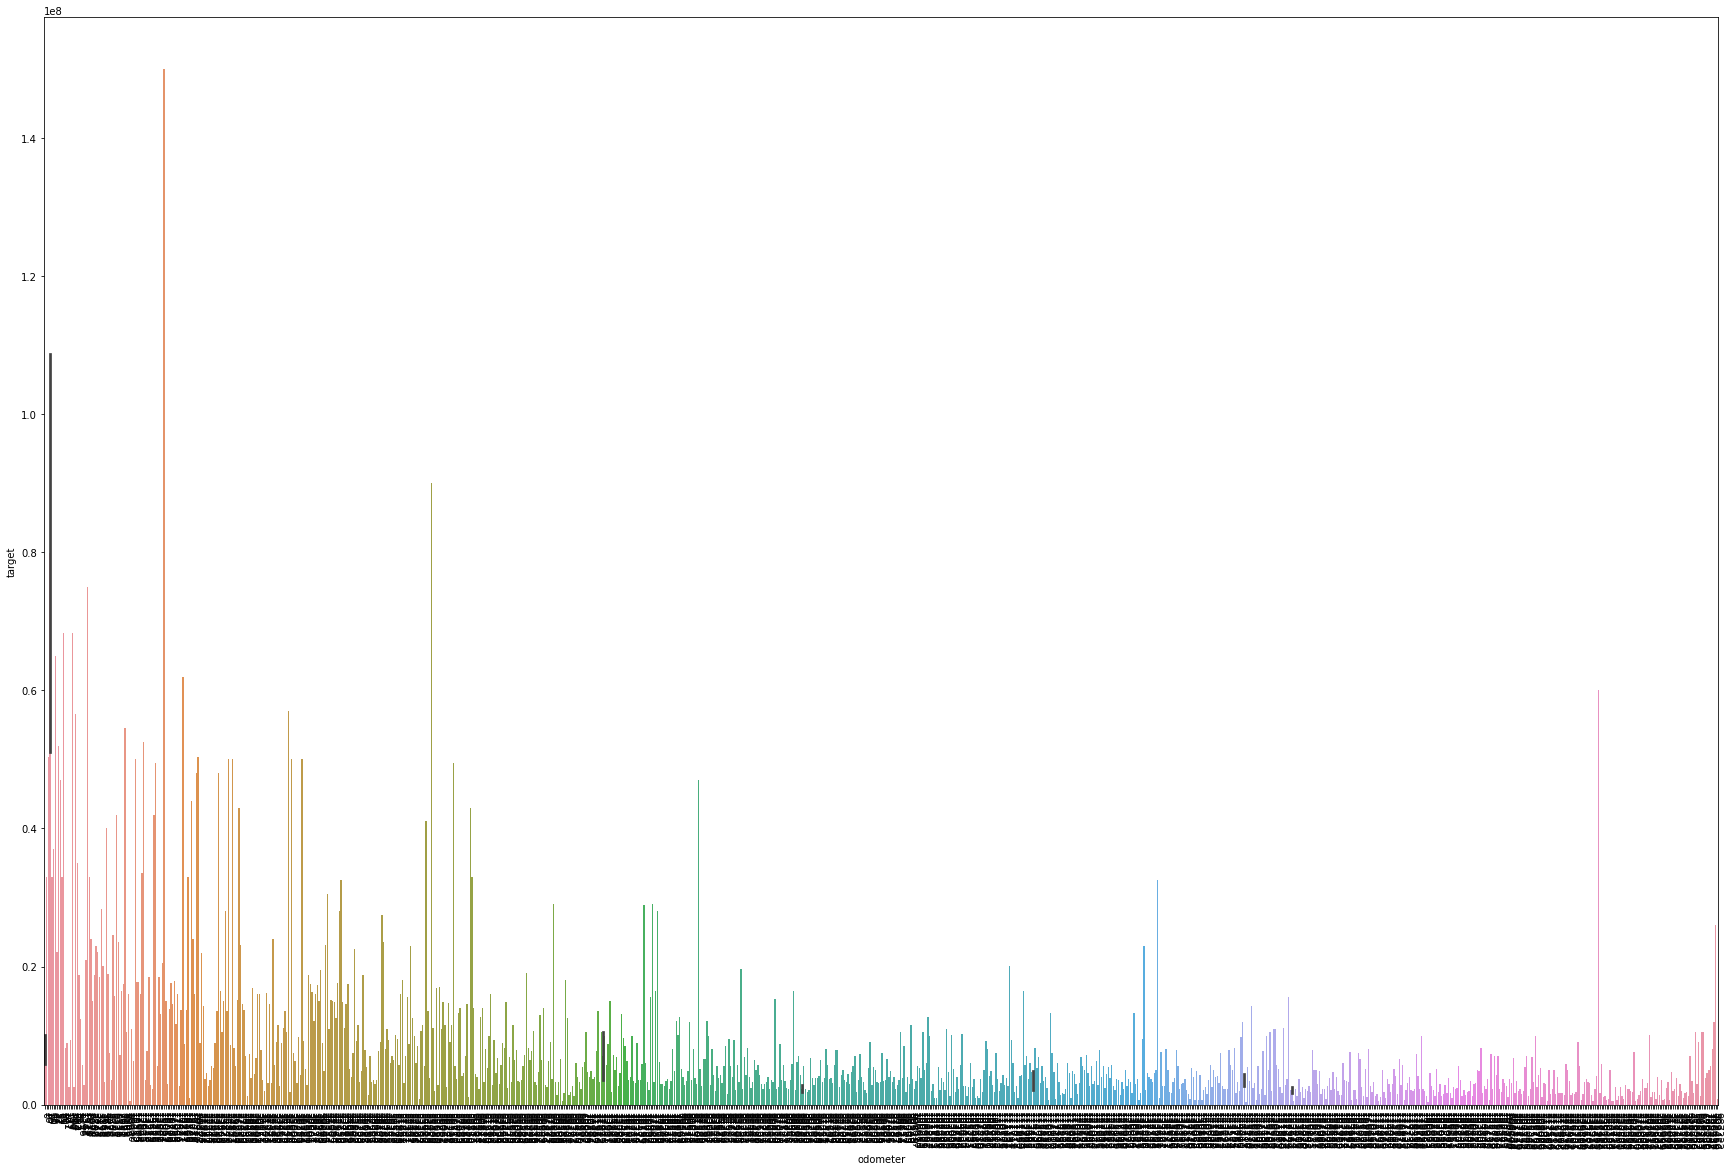

In [3]:
#odometer비교
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30,20))
plt.xticks(rotation = - 90 )
sns.barplot(x='odometer',y='target',data=train)

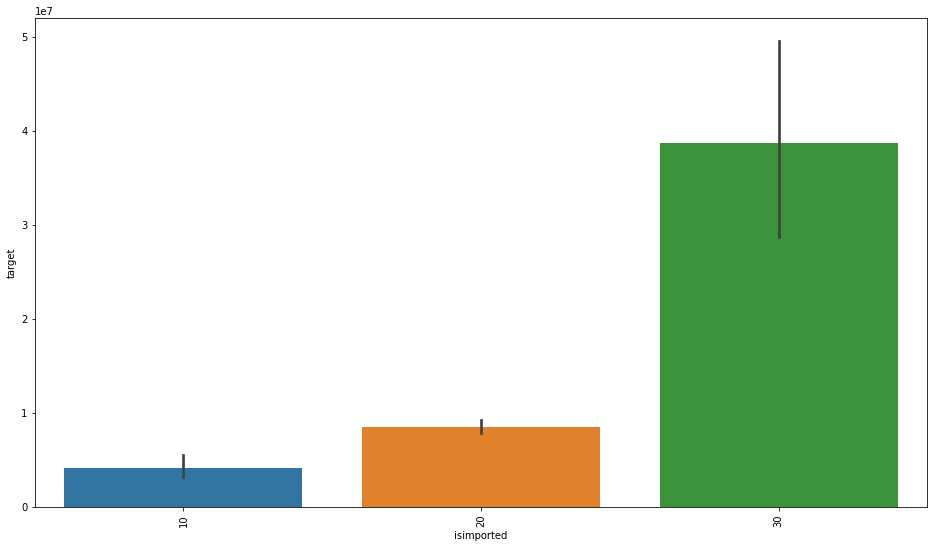

In [4]:
plt.figure(figsize=(16,9))
plt.xticks(rotation = 90 )
sns.barplot(x='isimported',y='target',data=train)

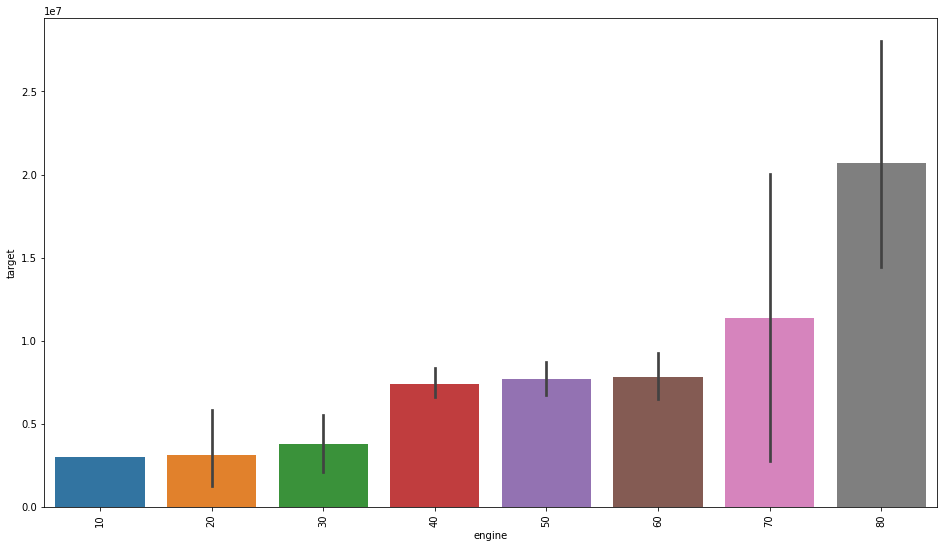

In [5]:
#엔진
plt.figure(figsize=(16,9))
plt.xticks(rotation = 90 )
sns.barplot(x='engine',y='target',data=train)

In [ ]:
target=train['target']
target.describe()

count    1.013000e+03
mean     8.160427e+06
std      1.173995e+07
min      4.000000e+05
25%      2.545000e+06
50%      4.215000e+06
75%      8.940000e+06
max      1.500150e+08
Name: target, dtype: float64

In [ ]:
train.shape
X=train.drop(['id', 'target'], axis = 1)
Y=train.target

In [11]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.25) #25프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 target 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #validation 데이터에서 target 추출

학습시킬 train 셋 :  (759, 9)
검증할 val 셋 :  (254, 9)


In [12]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as ltb

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False))
models.append(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False))
models.append(GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False))
models.append(ltb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

for model in models:
  model.fit(train_data_X, train_data_y)
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
  if prediction is None:
    prediction=model.predict(val_data_X)
  else:
    prediction+=model.predict(val_data_X)
    
prediction/=len(models)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


모델 NMAE: 0.2933281224902875


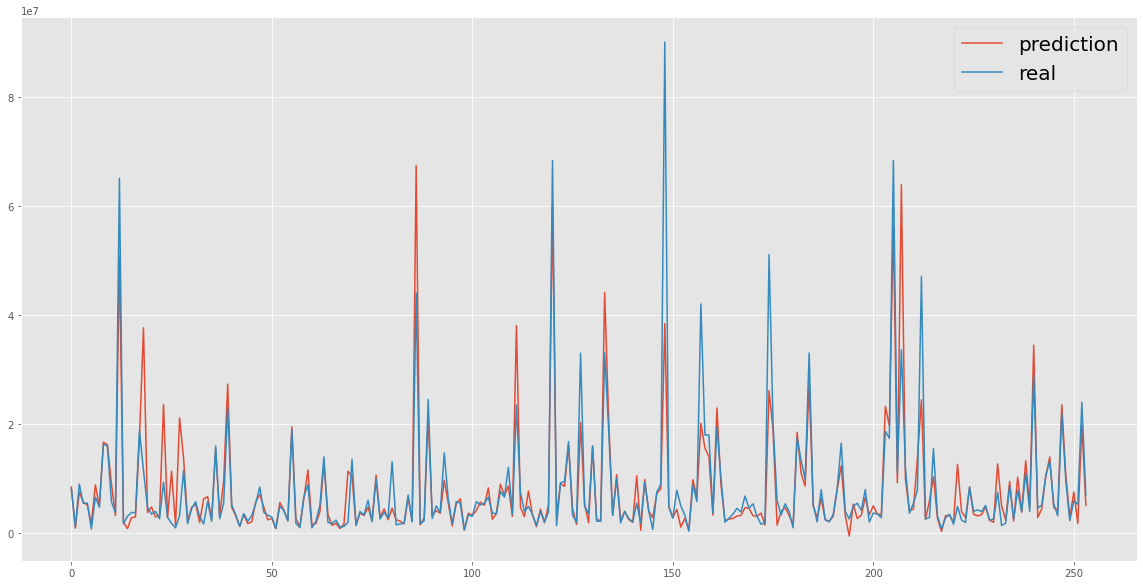

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
def nmae(true, pred):
  mae=np.mean(np.abs(true-pred))
  score=mae/np.mean(np.abs(true))
  return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [ ]:
#앙상블 기법으로 학습하여 최종 제출파일 생성
#train & test 전부 활용
train_X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 target 추출
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(ExtraTreesRegressor(n_estimators=110))
models.append(RandomForestRegressor(n_estimators=110))
models.append(GradientBoostingRegressor(learning_rate=0.22, criterion='mae'))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습
for model in models:
  model.fit(train_X, train_y)

prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(test)
    else:
        prediction += model.predict(test)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)
y_pred = model.predict(test)
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission['target'] = y_pred
submission.head()
submission.to_csv('/content/drive/MyDrive/submit4.csv', index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  max_depth,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  max_depth,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  max_depth,
/usr/local/lib/python3.7/dist-packages/sklear

In [ ]:
!pip install pycaret
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 31.0 MB/s 
     |████████████████████████████████| 6.8 MB 51.1 MB/s 
     |████████████████████████████████| 88 kB 7.6 MB/s 
     |████████████████████████████████| 167 kB 13.2 MB/s 
     |████████████████████████████████| 1.7 MB 55.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 262 kB 39.5 MB/s 
     |████████████████████████████████| 17.8 MB 310 kB/s 
     |████████████████████████████████| 120 kB 65.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 2.0 MB 17.7 MB/s 
     |████████████████████████████████| 1.3 MB 39.9 MB/s 
     |████████████████████████████████| 1.3 MB 51.0 MB/s 
     |████████████████████████████████| 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:

import jinja2
from pycaret.classification import *

reg_test_1 = setup(data=train,
                   target='target',
                   train_size= 0.85,
                   #test_data=test,
                   remove_perfect_collinearity=False,
                   numeric_features = ['engine','location','isimported'],
                   fold=10,
                   session_id=42
                   )





,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1013, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best= compare_models(sort='Recall',n_select=4)
best
top5 = [rank for rank in best]
top5_tune = [tune_model(i) for i in top5]
blended = blend_models(estimator_list = best,
                       fold = 10,
                       #method = 'soft',
                       optimize='mae',
                       )
final_model = finalize_model(blended)
y_test = predict_model(final_model, data =test)
y_test = np.exp(y_test['Label'])

# histogram of scaled target
label_fix = np.exp(train.target) #*M_label
plt.hist(y_test, bins=100, label='model', alpha=0.5)
plt.hist(label_fix, bins=100, label='original', alpha=0.5)

plt.title('Histogram of predicted and original target')
plt.legend()
plt.show()

submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission['target'] = y_test
submission.to_csv('/content/drive/MyDrive/submit4.csv', index=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0460,0.0,0.0402,0.0080,0.0127,0.0333,0.0407
1,0.0698,0.0,0.0523,0.0108,0.0181,0.0531,0.0565
2,0.0349,0.0,0.0281,0.0067,0.0111,0.0211,0.0229
3,0.0349,0.0,0.0269,0.0041,0.0072,0.0222,0.0237
4,0.0465,0.0,0.0389,0.0150,0.0177,0.0333,0.0369
5,0.0233,0.0,0.0169,0.0026,0.0044,0.0130,0.0142
6,0.0465,0.0,0.0389,0.0062,0.0107,0.0352,0.0385
7,0.0233,0.0,0.0215,0.0017,0.0031,0.0104,0.0112
8,0.0349,0.0,0.0163,0.0071,0.0118,0.0230,0.0243


ValueError: ignored